In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from tqdm import tqdm
from experimentsetup import *
from preprocessingandrecords import *
from plotty import *

In [2]:
datafilename = "mill.mat"
data = loadmat(datafilename)
data = data['mill']
data = data[0]
print(len(data[0]))
SENSOR = 11 #Acoustic emission at table; # 12 is Acoustic emission at spindle 
dataset, labels = [], []
lens = []
CLASS_SUBSET = [1,16,7,3]
j = 0
for d in data:
    l = d[0][0][0]
    if l in CLASS_SUBSET:
        # if j > 20:
        #     print(j,l)
        if j in [7,8,9,10,11, 30,26,27,28,29, 31,32,33,35,38, 39,40,41,42,43]: # this is the subset in the paper figure
            ts = np.squeeze(d[SENSOR])
            dataset.append(zscore(ts,nan_policy='omit')) # NORMALIZE
            labels.append(str(l))
            lens.append(len(ts))
        j+=1
label_append = np.arange(len(labels))
label_colors = {"1":"r", "3":"b", "16":"salmon", "7":"yellowgreen"}
values,counts=np.unique(lens,return_counts=True)
for i in zip(values,counts):
    print(i)

13
(9000, 20)


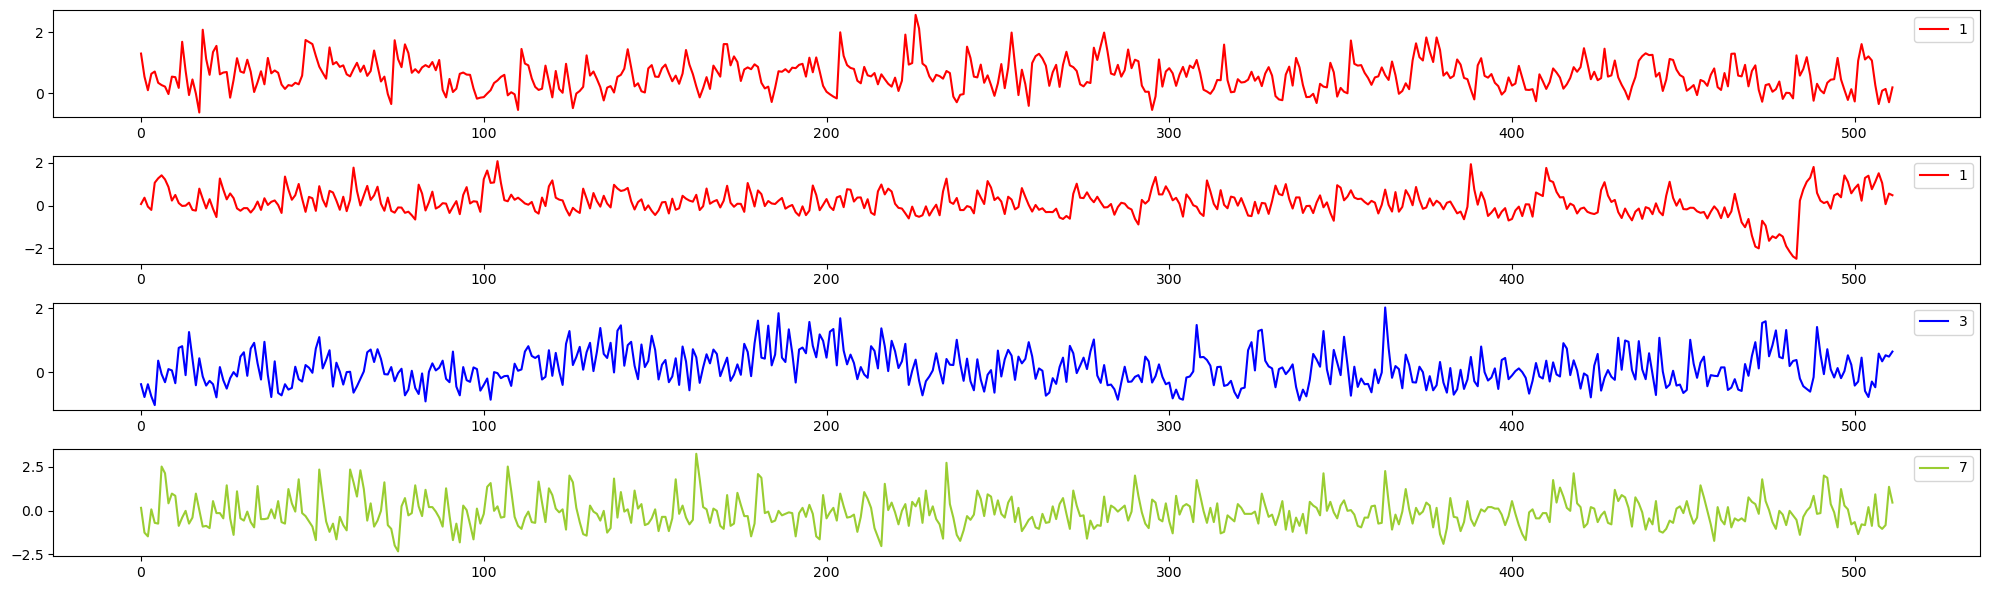

In [3]:
# Z-scored data data sample
fig,axs = plt.subplots(4,1,figsize=(20,6))
axs[0].plot(dataset[0][3000:3512],label=labels[0],c=label_colors[labels[0]])
axs[1].plot(dataset[4][3000:3512],label=labels[4],c=label_colors[labels[4]])
axs[2].plot(dataset[8][3000:3512],label=labels[8],c=label_colors[labels[8]])
axs[3].plot(dataset[12][3000:3512],label=labels[12],c=label_colors[labels[12]])
for i in range(4):
    axs[i].legend()
plt.show()


In [89]:
e = Experiment("PRECIS", [4,500], algyield=True, multivariate=False)
use_dicts = []
lens = []
for ts_idx in tqdm(range(len(dataset))):
    ts = dataset[ts_idx]
    d, idxs = e.make_exemplar(ts)
    for i in d:
        lens.append(len(i))
    use_dicts.append(d)

distmat = e.distmat_from_dicts(use_dicts)

Make Distmat: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


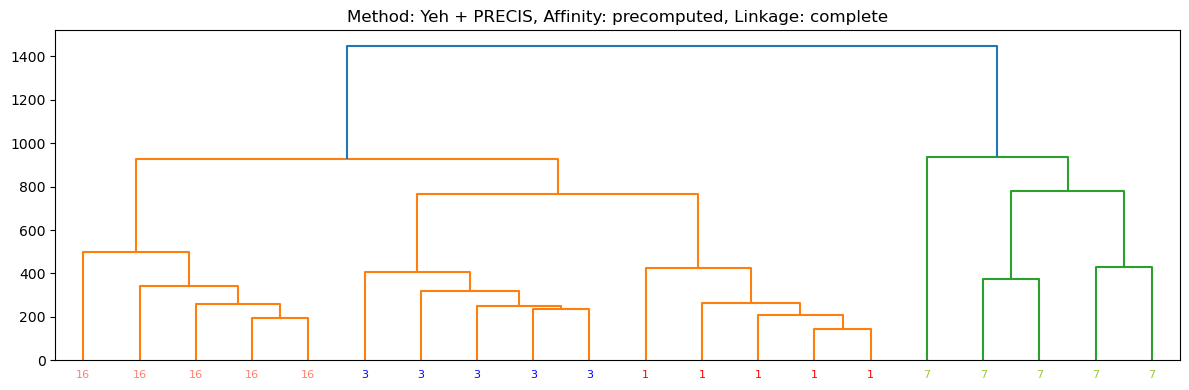

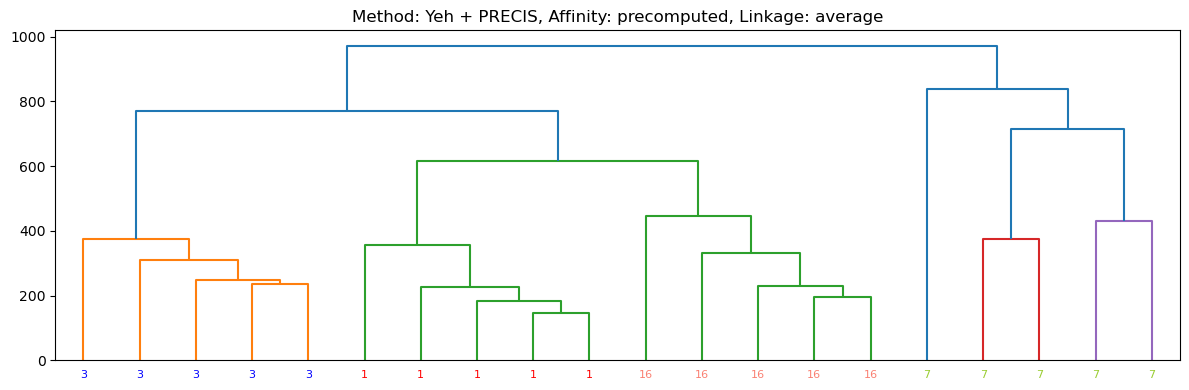

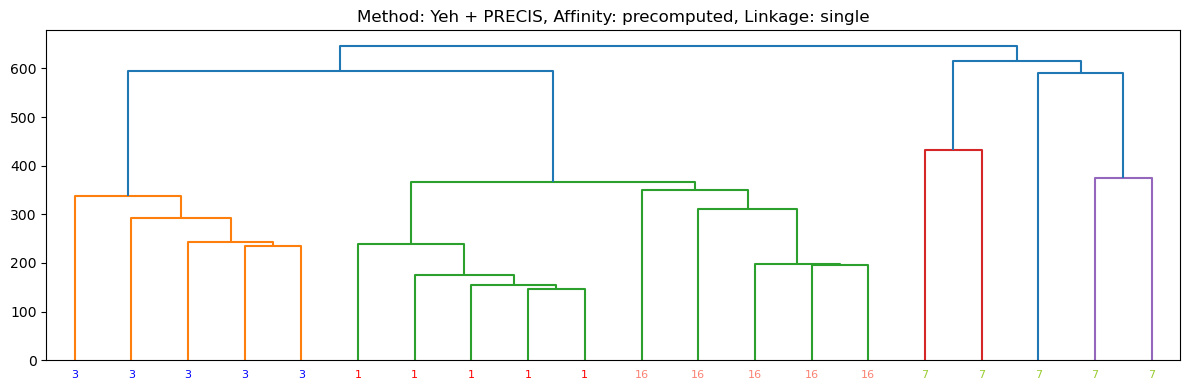

In [91]:
plotty_ac("/home/ader003/PRECIS_Materials/NASAMill_CLU.svg", "Yeh + PRECIS",'precomputed', 'complete', distmat, labels, label_colors)
plotty_ac(None, "Yeh + PRECIS",'precomputed', 'average', distmat, labels, label_colors)
plotty_ac(None, "Yeh + PRECIS",'precomputed', 'single', distmat, labels, label_colors)

# k-Shape Comparison

In [5]:
# kshape comparison
import time
from kshape.core import kshape, zscore
# https://github.com/johnpaparrizos/kshape: Under Usage in GitHub README, "Returns list of tuples with the clusters found by kshape. The first value of the tuple is zscore normalized centroid. The second value of the tuple is the index of assigned series to this cluster." 

STARTTIME = time.time()
clusters = kshape(dataset, 4)
ENDTIME = time.time()
print("Time elapsed: {}".format(ENDTIME-STARTTIME)) # this may take a few minutes

Time elapsed: 2602.115114212036


In [6]:
c = [i[1] for i in clusters]
for j in c:
    print(np.asarray(labels)[j])

['3' '3' '3' '3' '3' '7']
['1' '1' '1' '1' '1' '7']
['16' '16' '16']
['7' '7' '7' '16' '16']


In [ ]:
# kshape output
# Time elapsed: 2602.115114212036
# ['3' '3' '3' '3' '3' '7']
# ['1' '1' '1' '1' '1' '7']
# ['16' '16' '16']
# ['7' '7' '7' '16' '16']

# Catch 22

100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


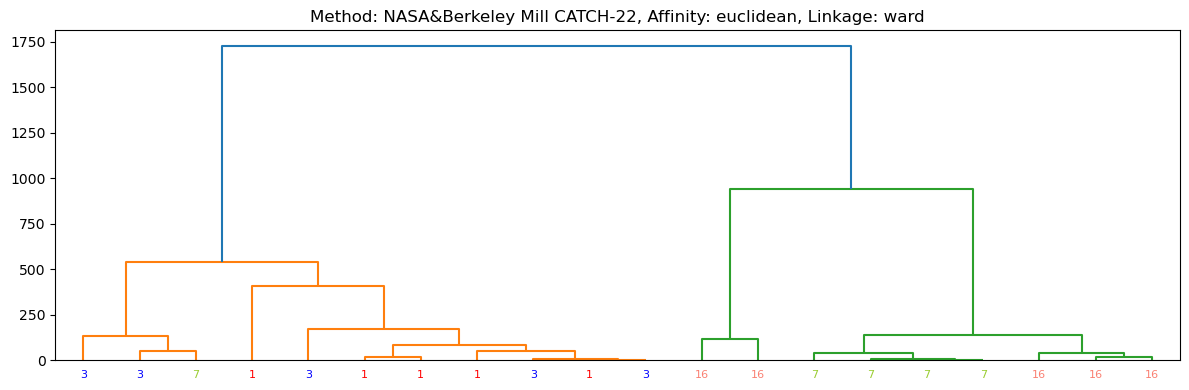

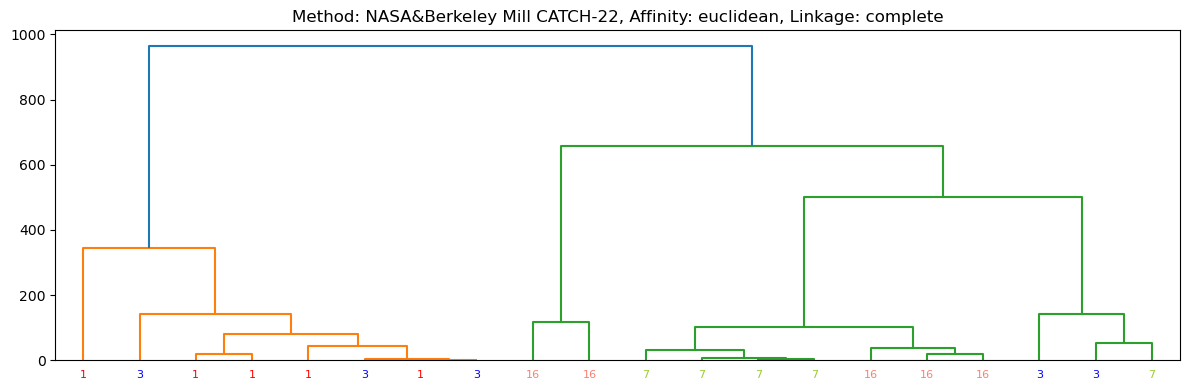

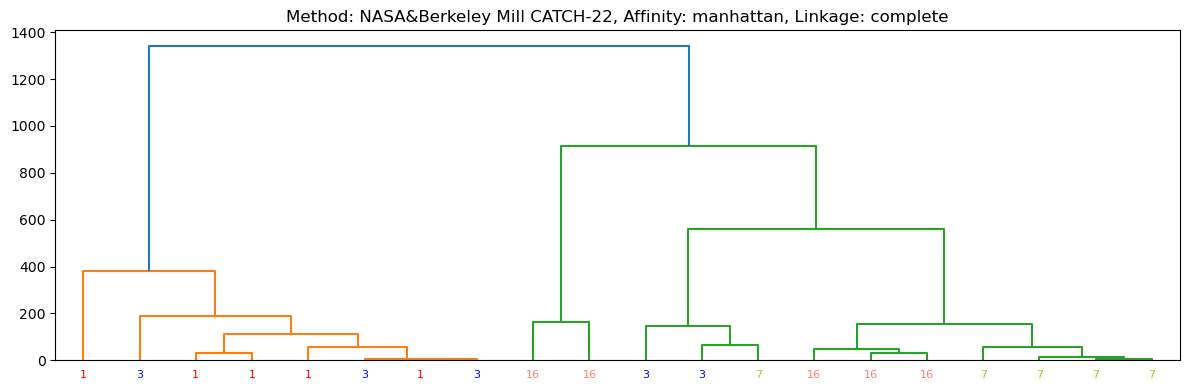

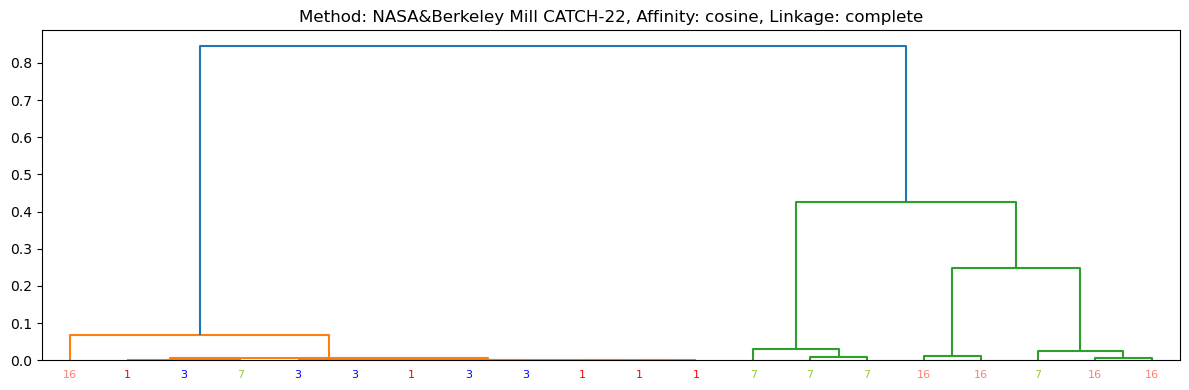

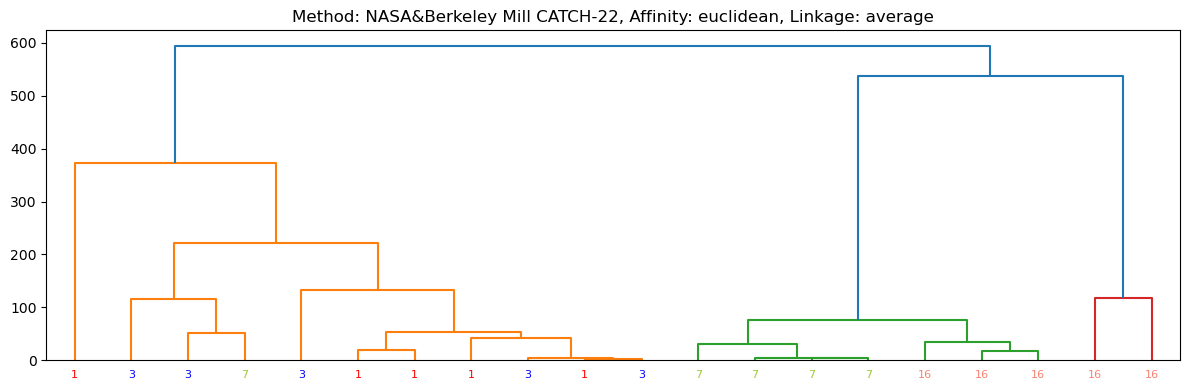

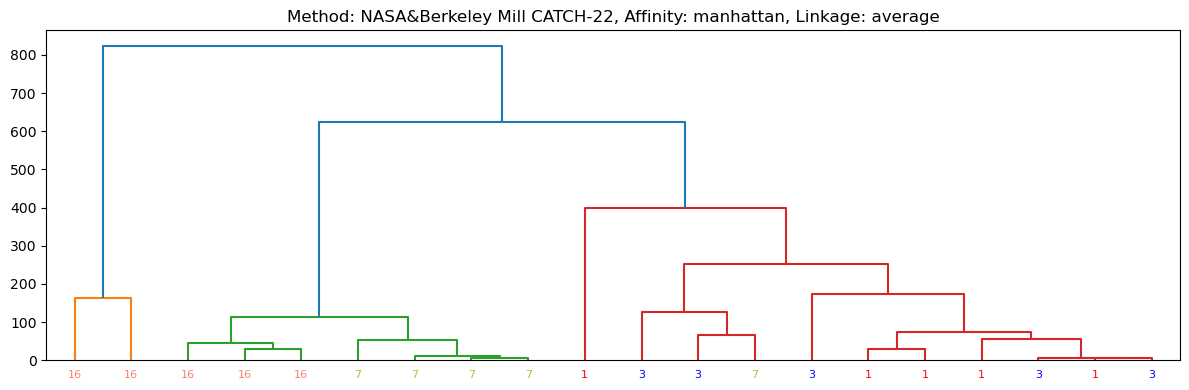

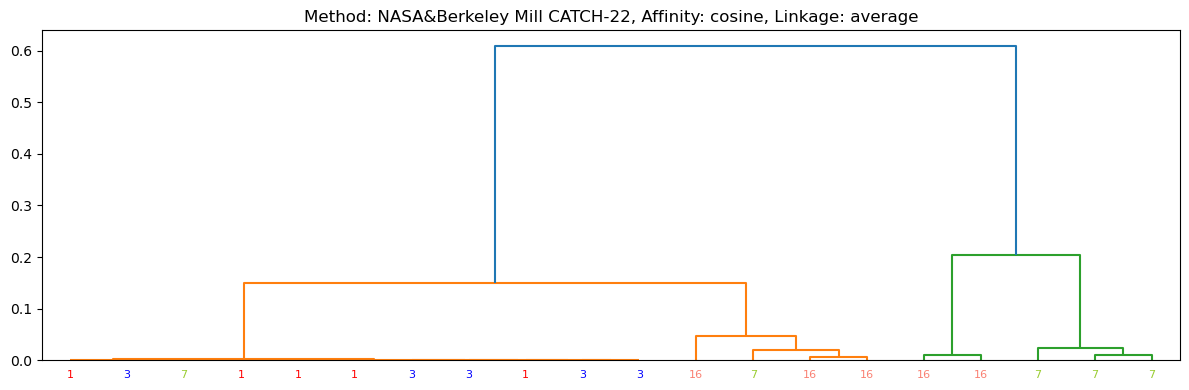

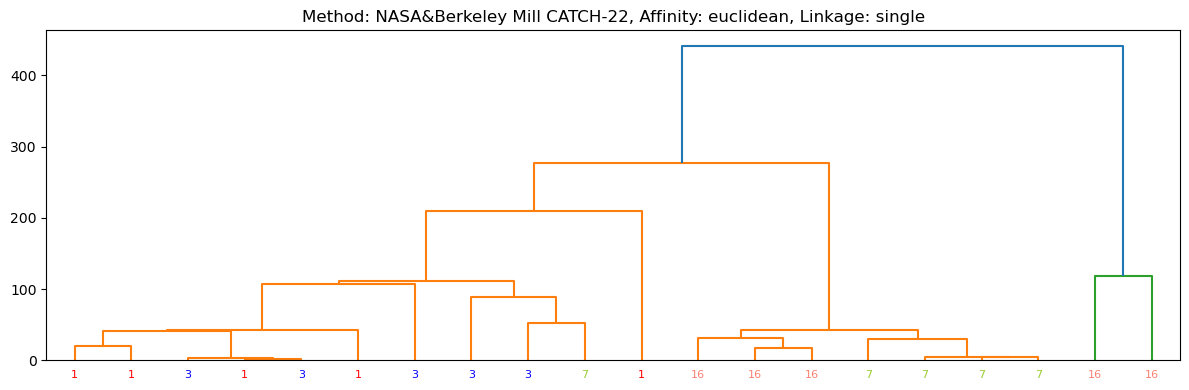

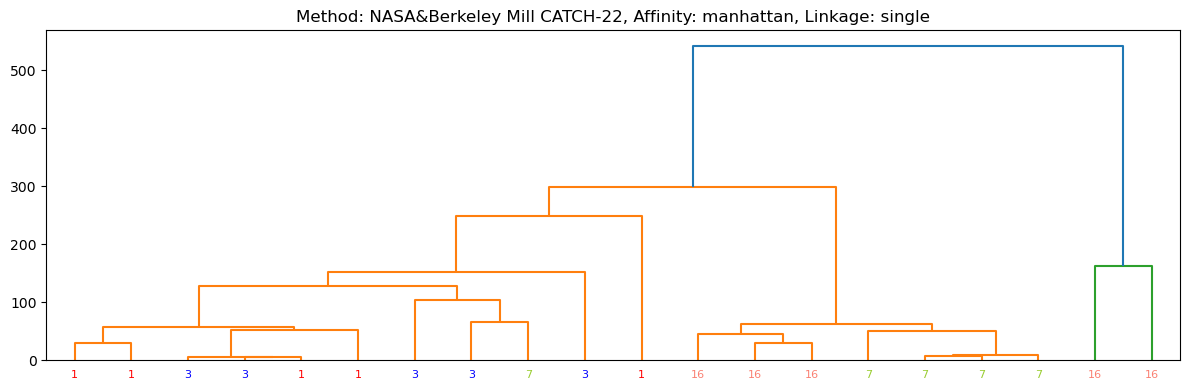

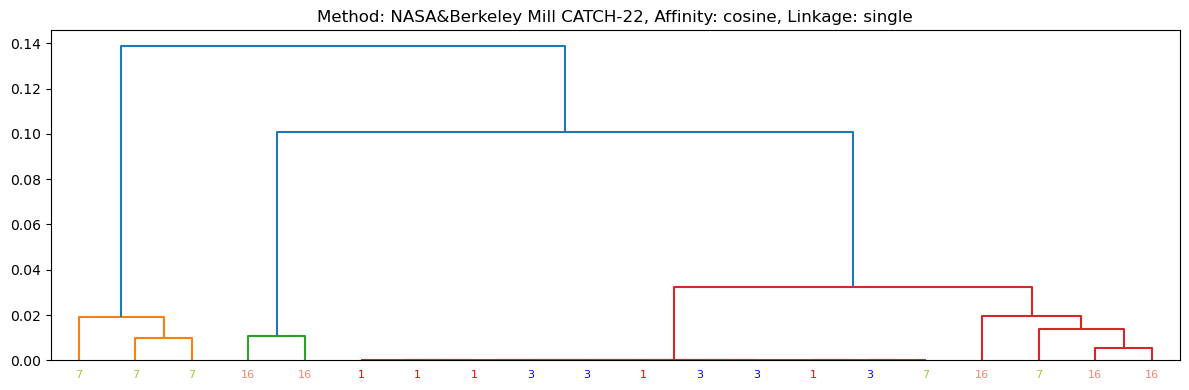

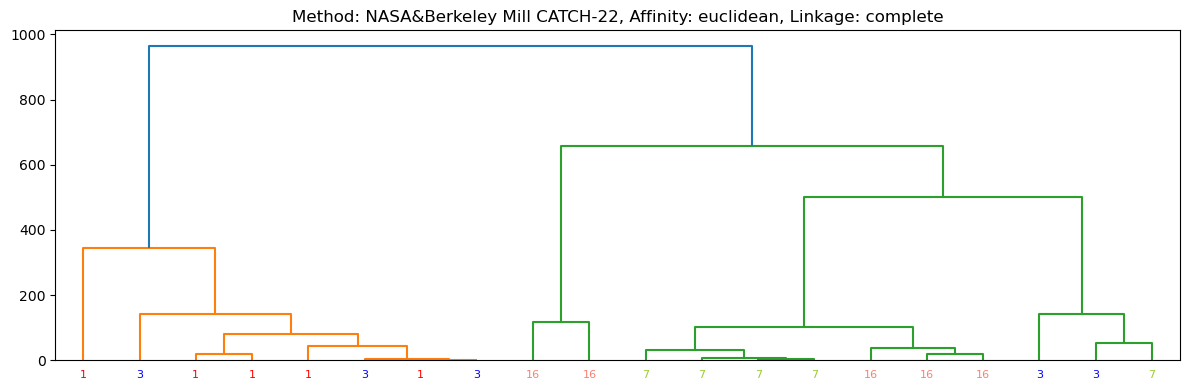

In [5]:
import catch22 # znorm internally

observationvectors = []
fsobservationvectors = []
for i in tqdm(range(len(dataset))):
    ts = dataset[i]
    fV = catch22.catch22_all(ts)
    fV_values = np.array(fV['values'])
    observationvectors.append(fV_values) 

rootsavename = "<directory to save figures to>"
linkagetypes = ['ward','complete', 'average', 'single']
affinities = ['euclidean','manhattan', 'cosine'] #l2 and l1 are also accepted, but are redundant
for linkage in linkagetypes:
    for affinity in affinities:
        if linkage == 'ward':
            # plotty_ac(rootsavename+"euclidean{}.svg".format(linkage), "CATCH-22", "euclidean", linkage, observationvectors, fref, label_colors)
            plotty_ac(None, "NASA&Berkeley Mill CATCH-22", "euclidean", linkage, observationvectors, labels, label_colors)
            break
        else:
            # plotty_ac(rootsavename+"{}{}.svg".format(affinity,linkage), "CATCH-22",affinity,linkage,observationvectors,fref,label_colors)
            plotty_ac(None, "NASA&Berkeley Mill CATCH-22", affinity, linkage, observationvectors, labels, label_colors)

plotty_ac("/home/ader003/PRECIS_Materials/NASABerkeleyMill_C22_Complete.svg", "NASA&Berkeley Mill CATCH-22", "euclidean", "complete", observationvectors, labels, label_colors)

# Cluster by Period

In [8]:
# Period comparison
from scipy.signal import find_peaks
import scipy.stats

def findperiods(data):
    l = len(data)
    period_mat = np.empty((l,l))
    dt = 1/1000 # sampling rate
    for i in range(l):
        for j in range(l):
            a = data[i]
            b = data[j]
            ac = np.correlate(a,b,"full")
            peaks = find_peaks(ac,np.arange(0,len(ac)))
            peak_idxs = peaks[0]
            period = np.mean(np.diff(peak_idxs)*dt)
            if np.isnan(period):
                period = 17976931348623157 # stupidly large number
            period_mat[i,j] = period
    return period_mat

periods = findperiods(dataset)


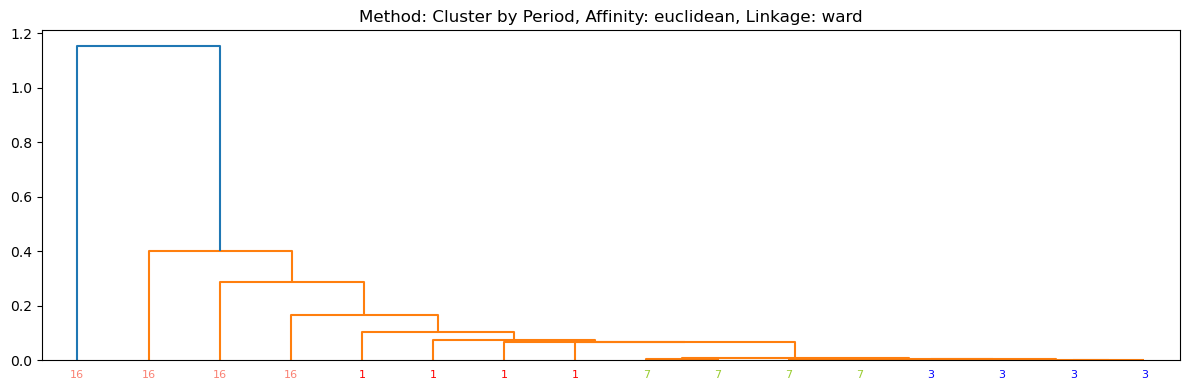

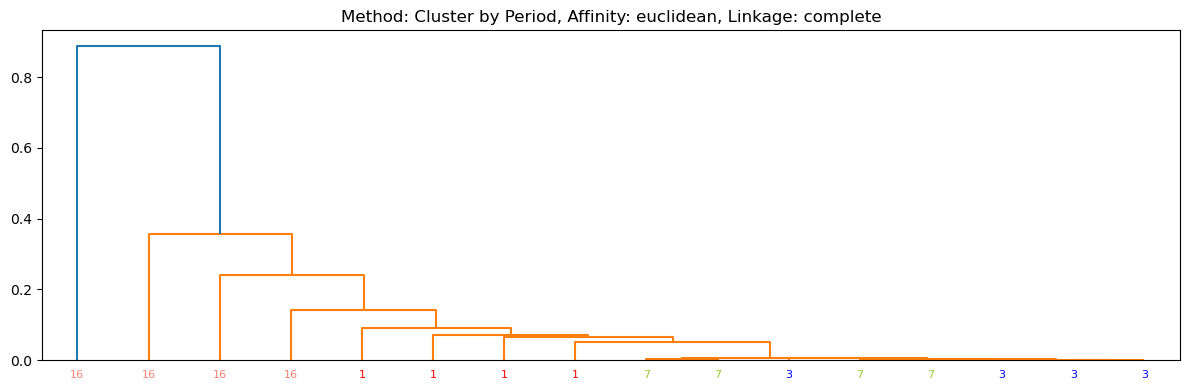

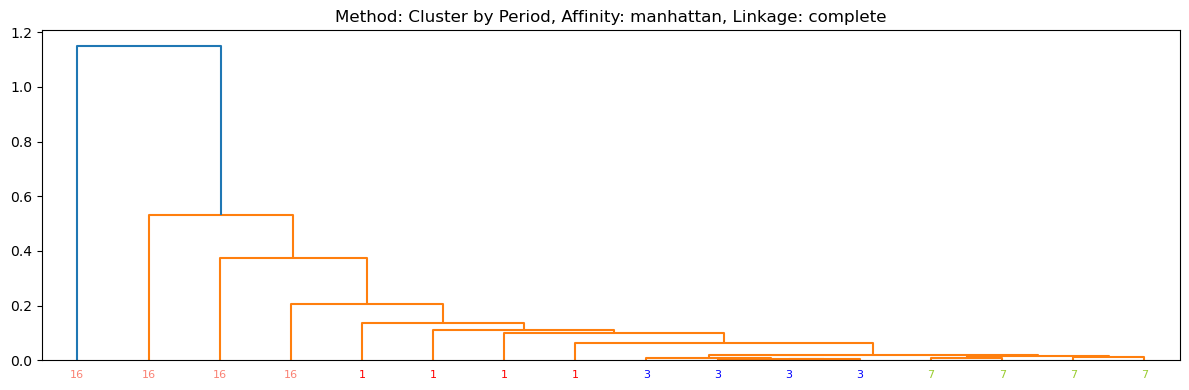

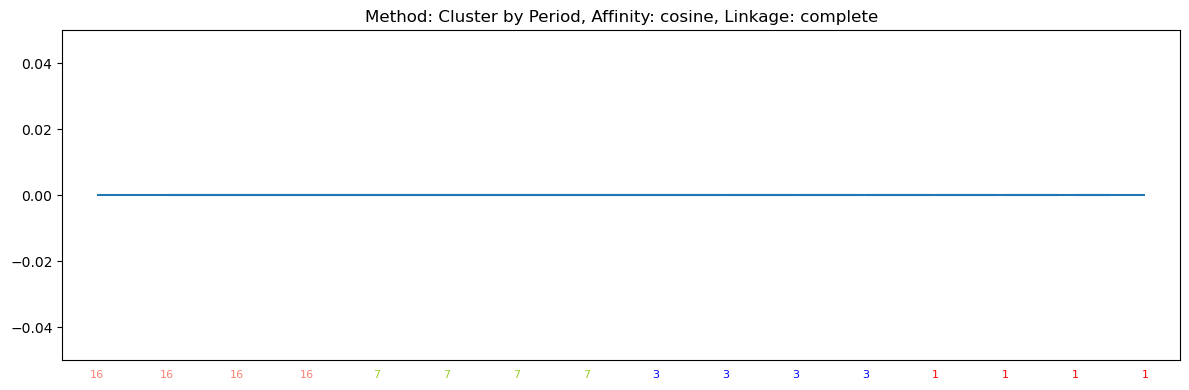

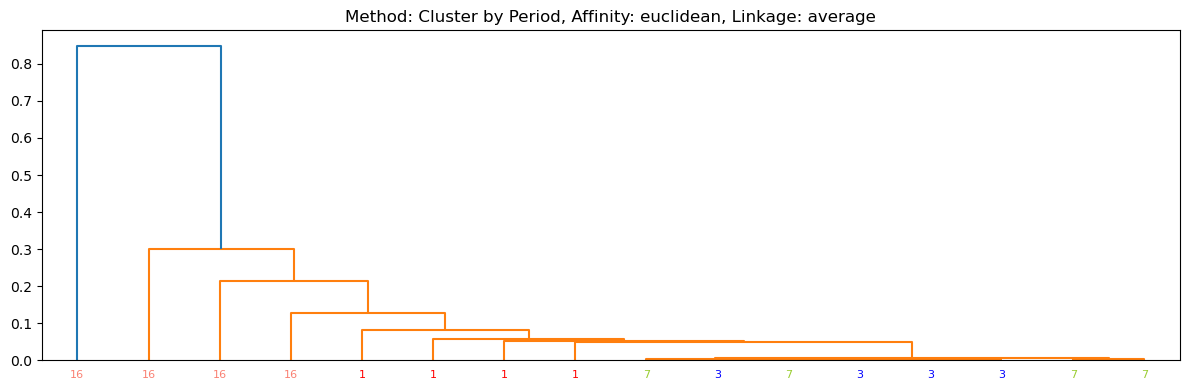

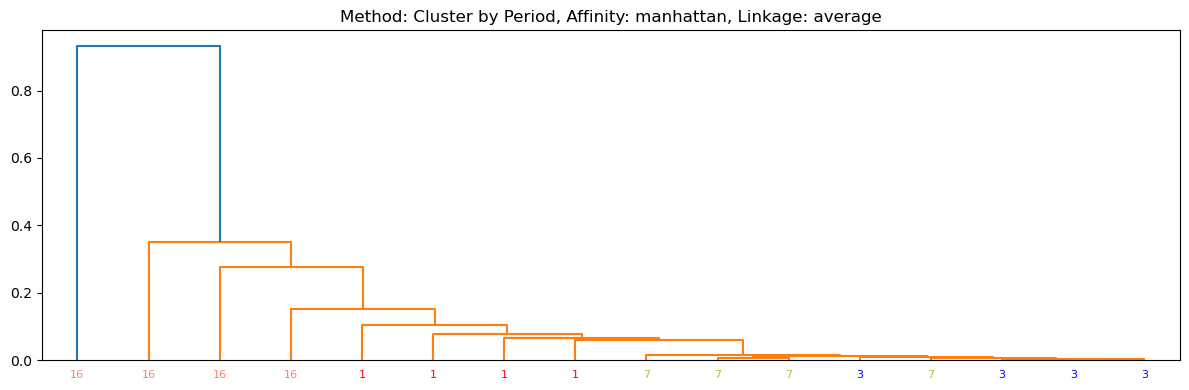

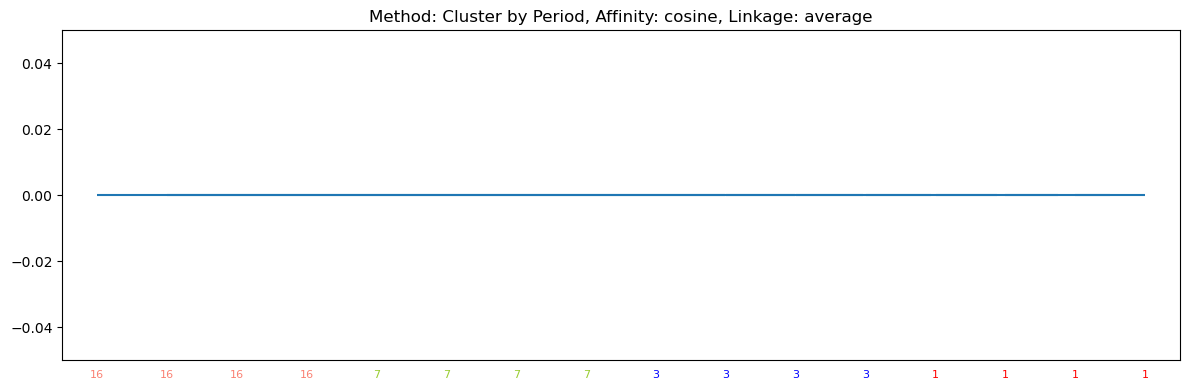

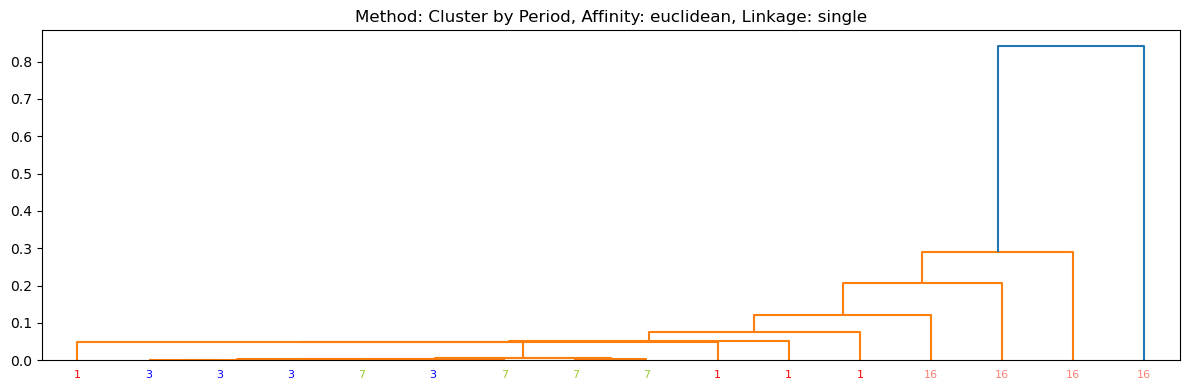

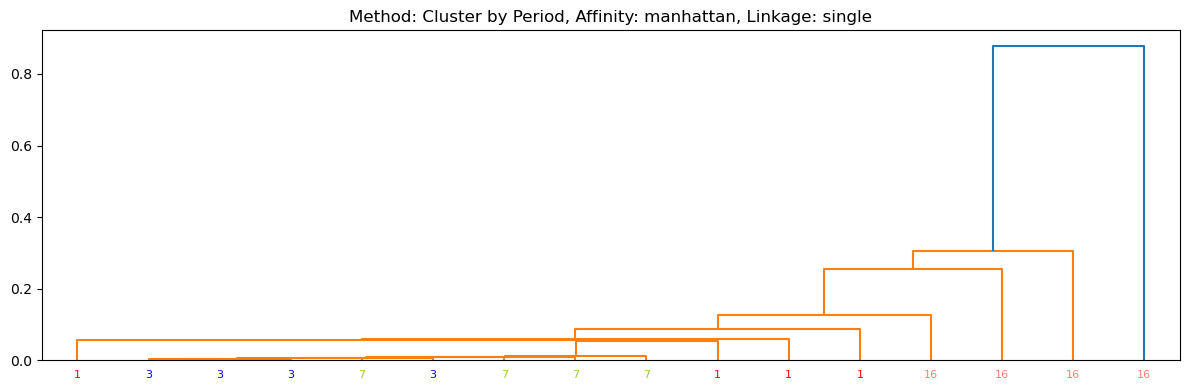

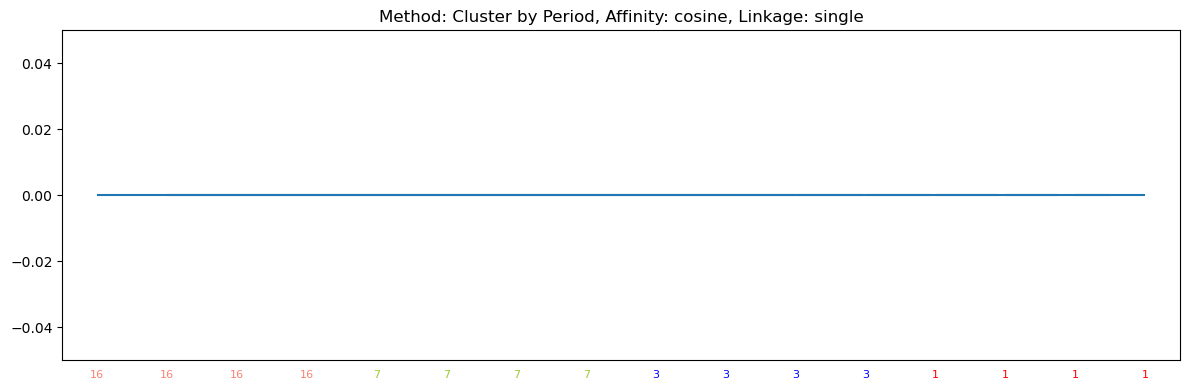

In [9]:
rootsavename = "<save figures here>"
linkagetypes = ['ward','complete', 'average', 'single']
affinities = ['euclidean','manhattan', 'cosine'] #l2 is also accepted, but is redundant
for linkage in linkagetypes:
    for affinity in affinities:
        if linkage == 'ward':
            # plotty_ac(rootsavename+"euclidean{}.svg".format(linkage), "CATCH-22", "euclidean", linkage, observationvectors, fref, label_colors)
            plotty_ac(None, "Cluster by Period", "euclidean", linkage, periods, labels, label_colors)
            break
        else:
            # plotty_ac(rootsavename+"{}{}.svg".format(affinity,linkage), "CATCH-22",affinity,linkage,observationvectors,fref,label_colors)
            plotty_ac(None, "Cluster by Period", affinity, linkage, periods, labels, label_colors)